In [1]:
from pymongo import MongoClient
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt


client = MongoClient()
db = client['spectra_database']
collection = db['icsd_bispectra_lmax4_radius3.1']
data = collection.find()


def contains_element(formula, element):
    return element in re.findall('([A-Z][a-z]*)', formula)


def num_elements(formula):
    return len(set(re.findall('([A-Z][a-z]*)', formula)))


transition_metals = {
    '3d': ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn'],
    '4d': ['Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd'],
    '5d': ['Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg'],
    '4f': ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho','Er', 'Tm', 'Yb', 'Lu'],
    '5f': ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
}


def get_transition_metal_series(chemical_formula): # TODO this does not handle multiple transition metals correctly
    elements = re.findall('([A-Z][a-z]*)', chemical_formula)
    transition_metal_series = "n/a"
    for series, metals in transition_metals.items():
        if any(metal in elements for metal in metals):
            # if transition_metal_series is not None:
            #     raise ValueError("Multiple transition metals found in the formula.")
            transition_metal_series = series
    return transition_metal_series

In [2]:
# Number of local environments

num_local_envs = collection.count_documents({})
print(f"Number of local environments: {num_local_envs}")

Number of local environments: 963895


In [3]:
# # Number of quaternary compounds = 403540

# db = client['spectra_database']
# collection = db['icsd_bispectra_lmax4_radius3.1']
# data = collection.find()

# num_quaternaries = 0
# for document in tqdm(data):
#     formula = document['cif_filepath'].split('/')[-1]
#     if num_elements(formula) == 4:
#         num_quaternaries += 1
# print(num_quaternaries)

In [4]:
db = client['spectra_database']
collection = db['icsd_bispectra_lmax4_radius3.1']
data = collection.find()

all_crystals = []
for document in tqdm(data):
    formula = document['cif_filepath'].split('/')[-1]
    if num_elements(formula) <= 6:
        transition_metal_series = get_transition_metal_series(formula)
        NOS_element = next((element for element in ['N', 'O', 'S'] if contains_element(formula, element)), None)
        boron_compound = "n/a"
        if contains_element(formula, 'B'):
            boron_compound = 'borate' if contains_element(formula, 'O') else 'boride'
        all_crystals.append([formula, transition_metal_series, NOS_element, boron_compound, document['spectra']])

df_all_crystals = pd.DataFrame(all_crystals, columns=['formula', 'transition_metal_series', 'NOS_element', 'boron', 'spectra'])

963895it [00:13, 73578.87it/s] 


In [5]:
def perform_pca(df, column_filters, filter_values):
    df_filtered = df.copy()
    for column_filter, filter_value in zip(column_filters, filter_values):
        df_filtered = df_filtered[df_filtered[column_filter] != filter_value]
    spectra_list = df_filtered['spectra'].tolist()
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(spectra_list)
    df_filtered.loc[:, '1st Principal Component'] = principal_components[:,0]
    df_filtered.loc[:, '2nd Principal Component'] = principal_components[:,1]
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance explained by 1st Principal Component: {explained_variance[0]*100:.2f}%")
    print(f"Variance explained by 2nd Principal Component: {explained_variance[1]*100:.2f}%")
    return df_filtered

df_all_crystals = perform_pca(df_all_crystals, ['spectra'], [None])
df_transition_metal_crystals = perform_pca(df_all_crystals, ['transition_metal_series'], ['n/a'])


Variance explained by 1st Principal Component: 85.46%
Variance explained by 2nd Principal Component: 11.27%
Variance explained by 1st Principal Component: 81.38%
Variance explained by 2nd Principal Component: 10.43%


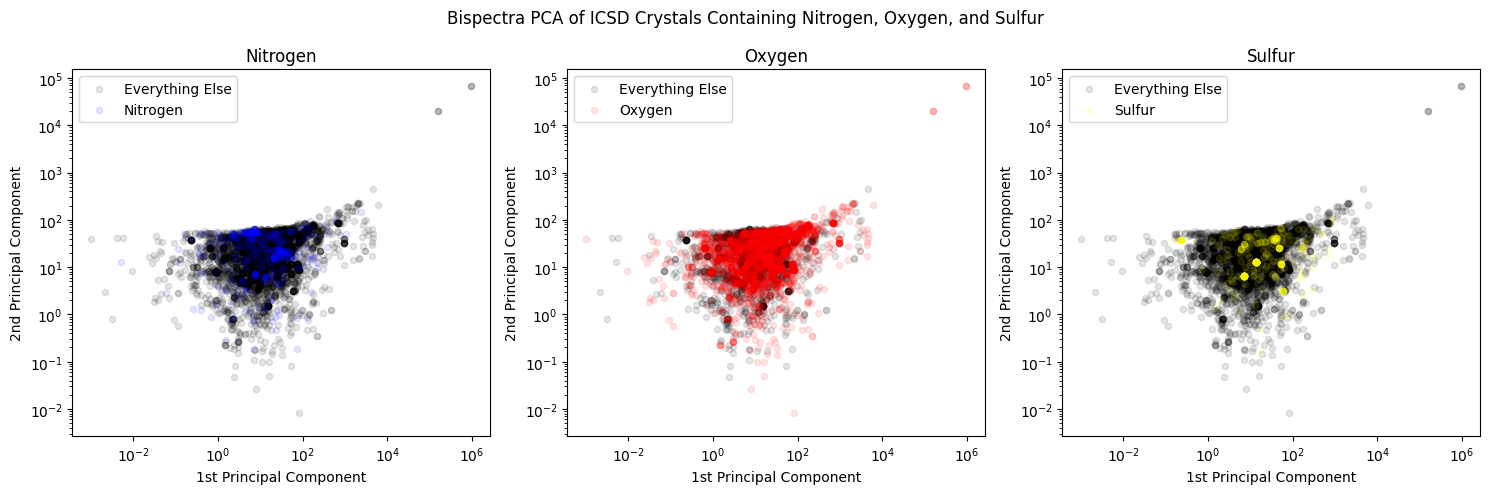

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Bispectra PCA of ICSD Crystals Containing Nitrogen, Oxygen, and Sulfur')

NOS_elements = ['N', 'O', 'S']
symbol_to_element = {'N': 'Nitrogen', 'O': 'Oxygen', 'S': 'Sulfur'}
colors = ['blue', 'red', 'yellow']

for ax, NOS_element, color in zip(axs, NOS_elements, colors):
    group = df_all_crystals[df_all_crystals['NOS_element'] == NOS_element]
    other_group = df_all_crystals[df_all_crystals['NOS_element'] != NOS_element]
    ax.set_title(f'{symbol_to_element[NOS_element]}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Everything Else')
    group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=color, alpha=0.1, label=symbol_to_element[NOS_element])
    ax.legend()

plt.tight_layout()
plt.show()

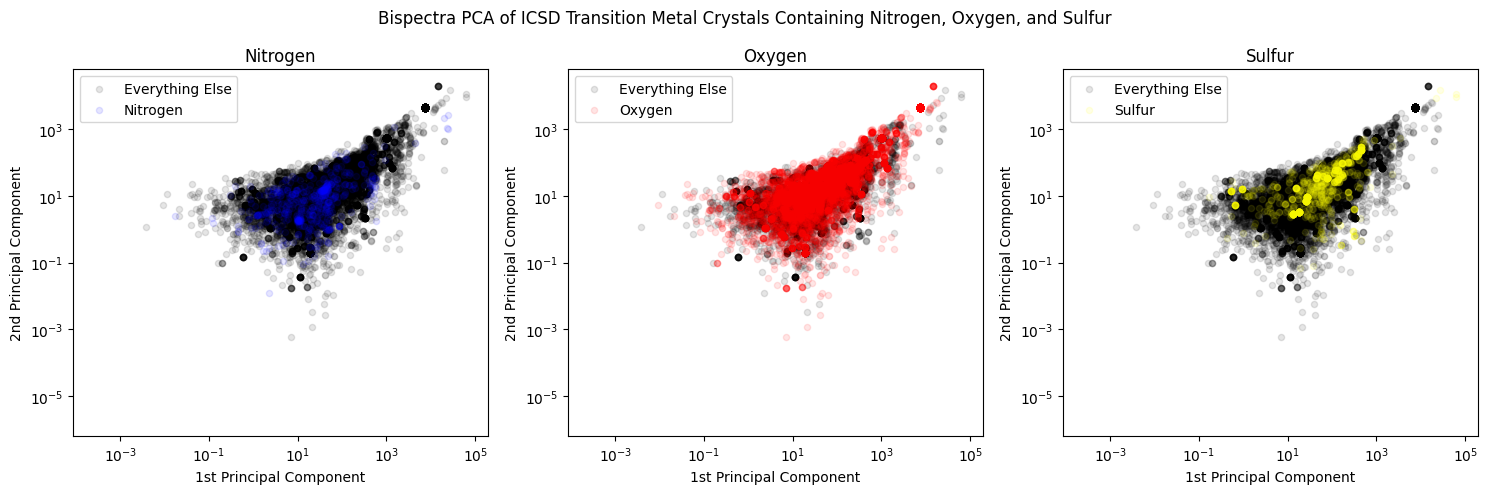

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Bispectra PCA of ICSD Transition Metal Crystals Containing Nitrogen, Oxygen, and Sulfur')

NOS_elements = ['N', 'O', 'S']
symbol_to_element = {'N': 'Nitrogen', 'O': 'Oxygen', 'S': 'Sulfur'}
colors = ['blue', 'red', 'yellow']

for ax, NOS_element, color in zip(axs, NOS_elements, colors):
    group = df_transition_metal_crystals[df_transition_metal_crystals['NOS_element'] == NOS_element]
    other_group = df_transition_metal_crystals[df_transition_metal_crystals['NOS_element'] != NOS_element]
    ax.set_title(f'{symbol_to_element[NOS_element]}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Everything Else')
    group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=color, alpha=0.1, label=symbol_to_element[NOS_element])
    ax.legend()

plt.tight_layout()
plt.show()

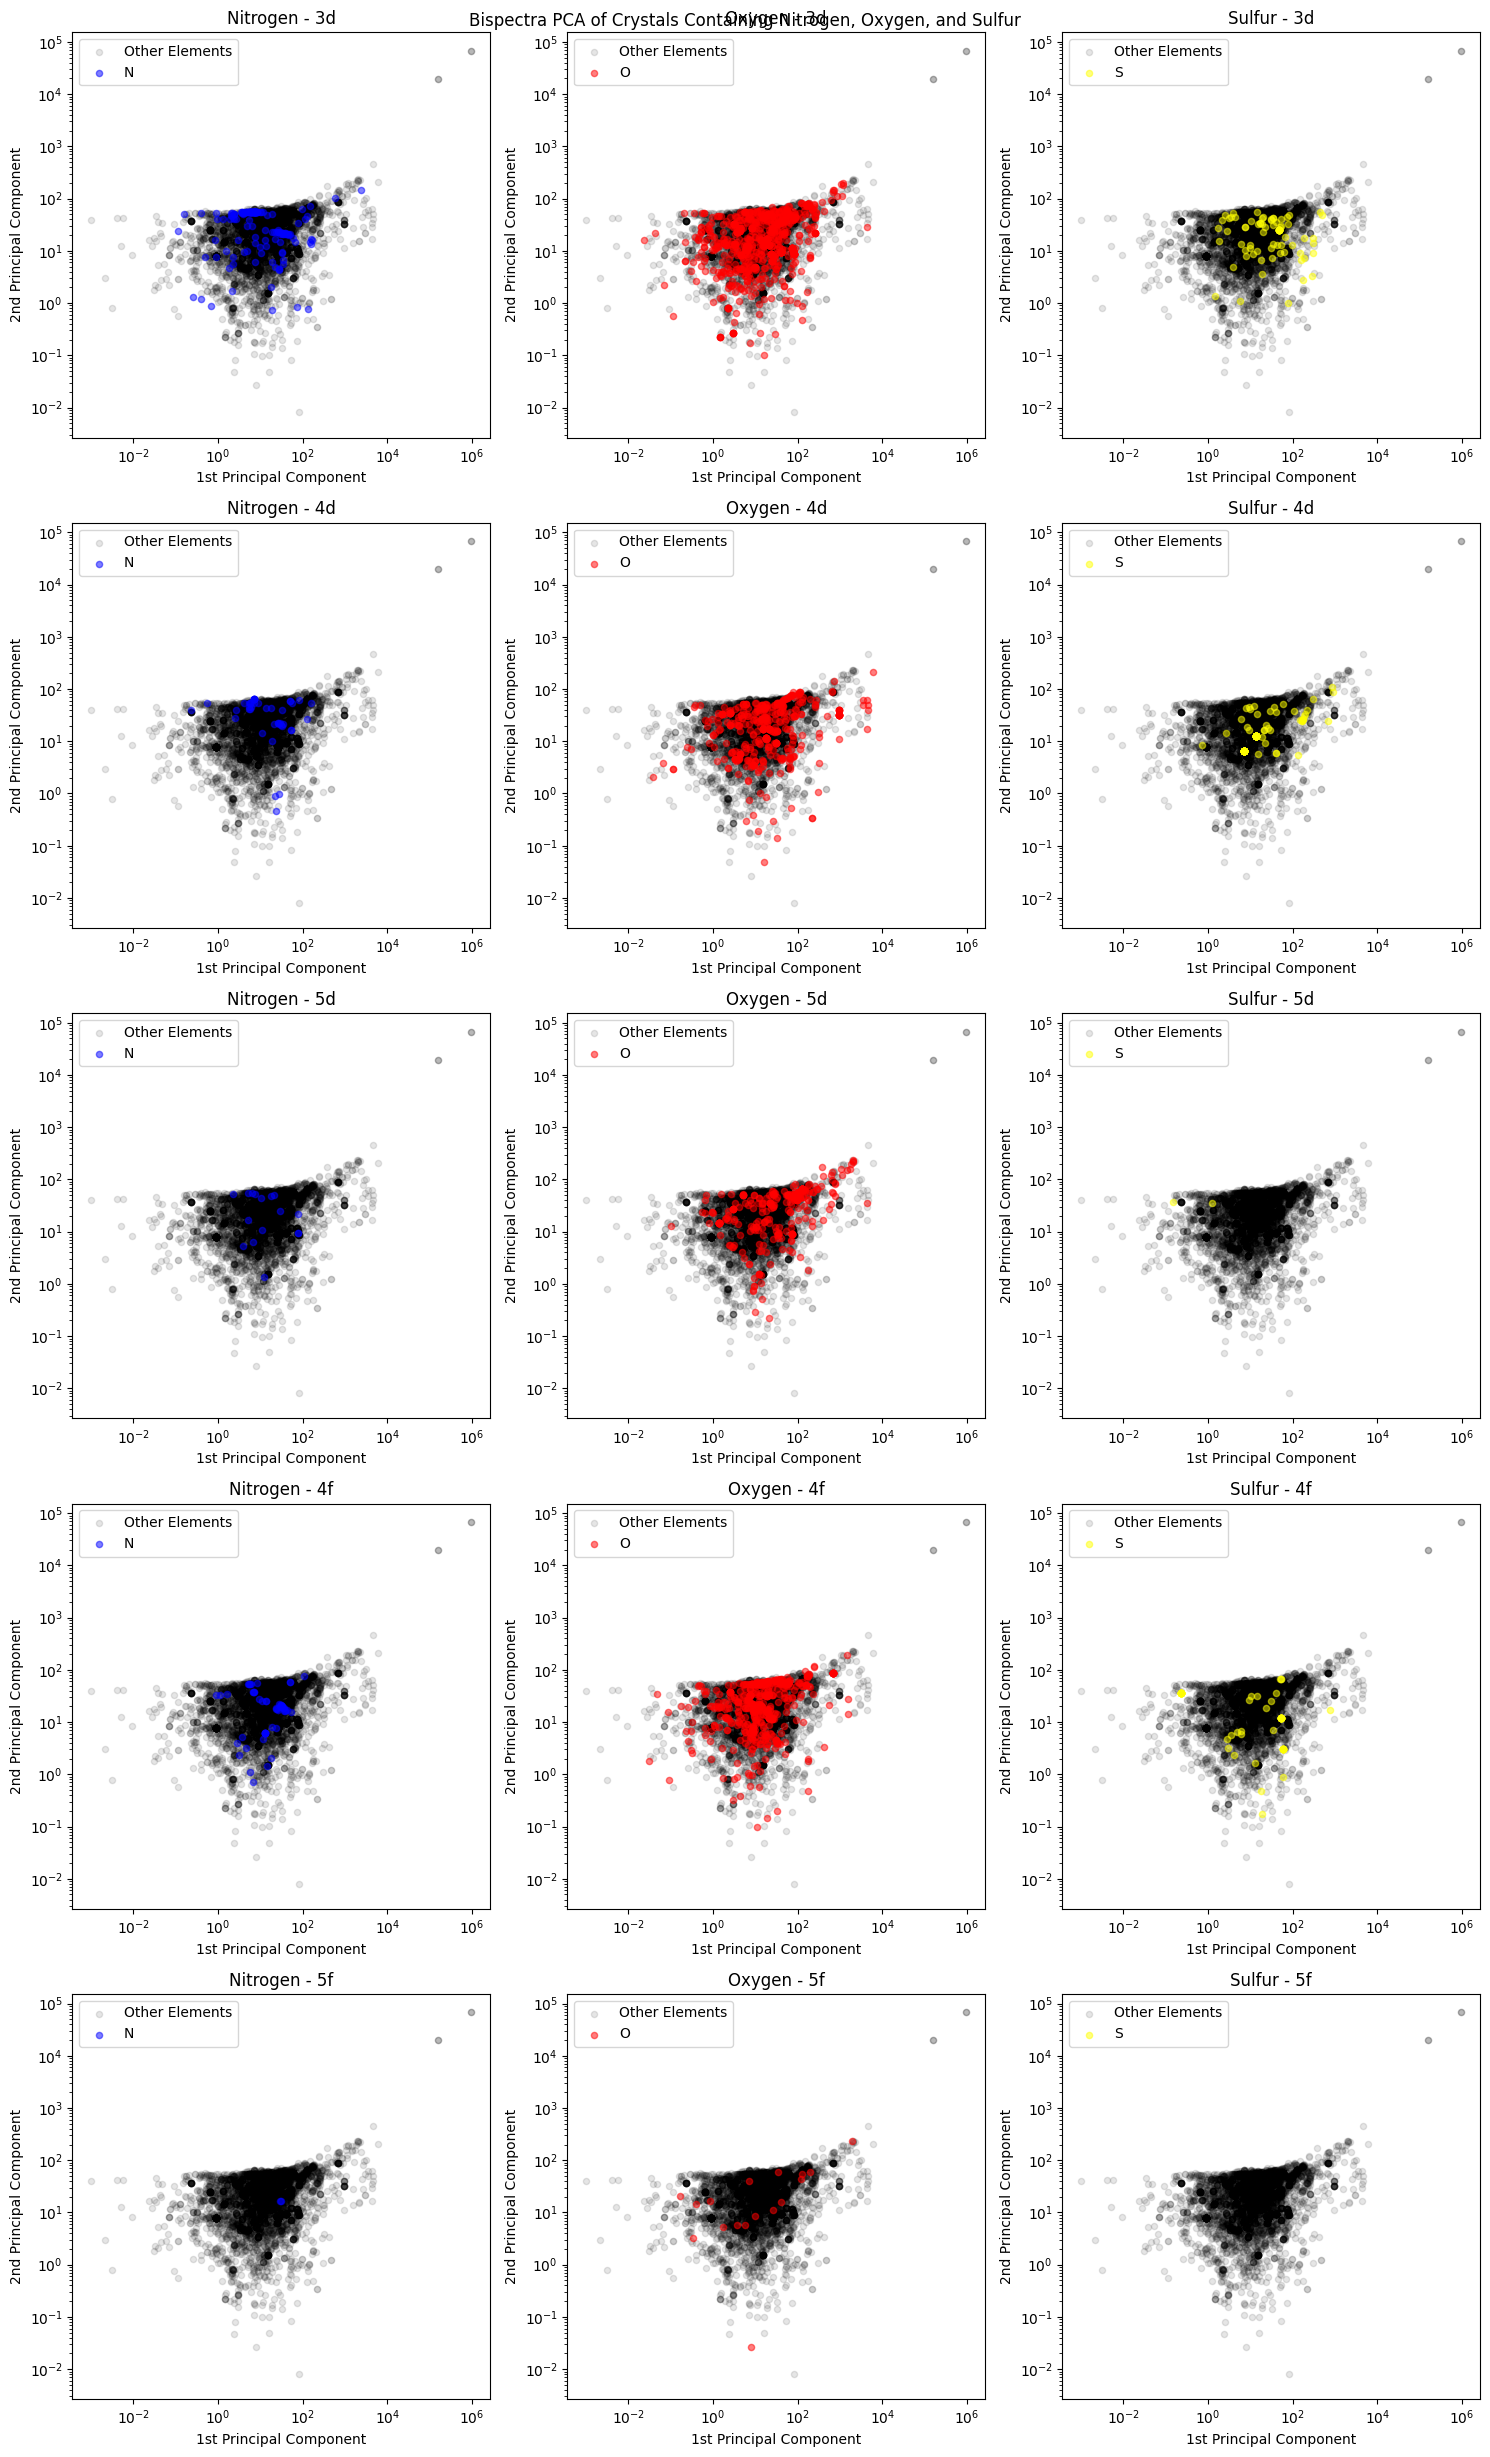

In [8]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle('Bispectra PCA of Crystals Containing Nitrogen, Oxygen, and Sulfur')

NOS_elements = ['N', 'O', 'S']
transition_metal_series = ['3d', '4d', '5d', '4f', '5f']
symbol_to_element = {'N': 'Nitrogen', 'O': 'Oxygen', 'S': 'Sulfur'}
colors = ['blue', 'red', 'yellow']

for i, NOS_element in enumerate(NOS_elements):
    for j, series in enumerate(transition_metal_series):
        ax = axs[j, i]
        group = df_all_crystals[(df_all_crystals['NOS_element'] == NOS_element) & (df_all_crystals['transition_metal_series'] == series)]
        other_group = df_all_crystals[(df_all_crystals['NOS_element'] != NOS_element) | (df_all_crystals['transition_metal_series'] != series)]
        ax.set_title(f'{symbol_to_element[NOS_element]} - {series}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Other Elements')
        group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=colors[i], alpha=0.5, label=NOS_element)
        ax.legend()

plt.tight_layout()
plt.show()


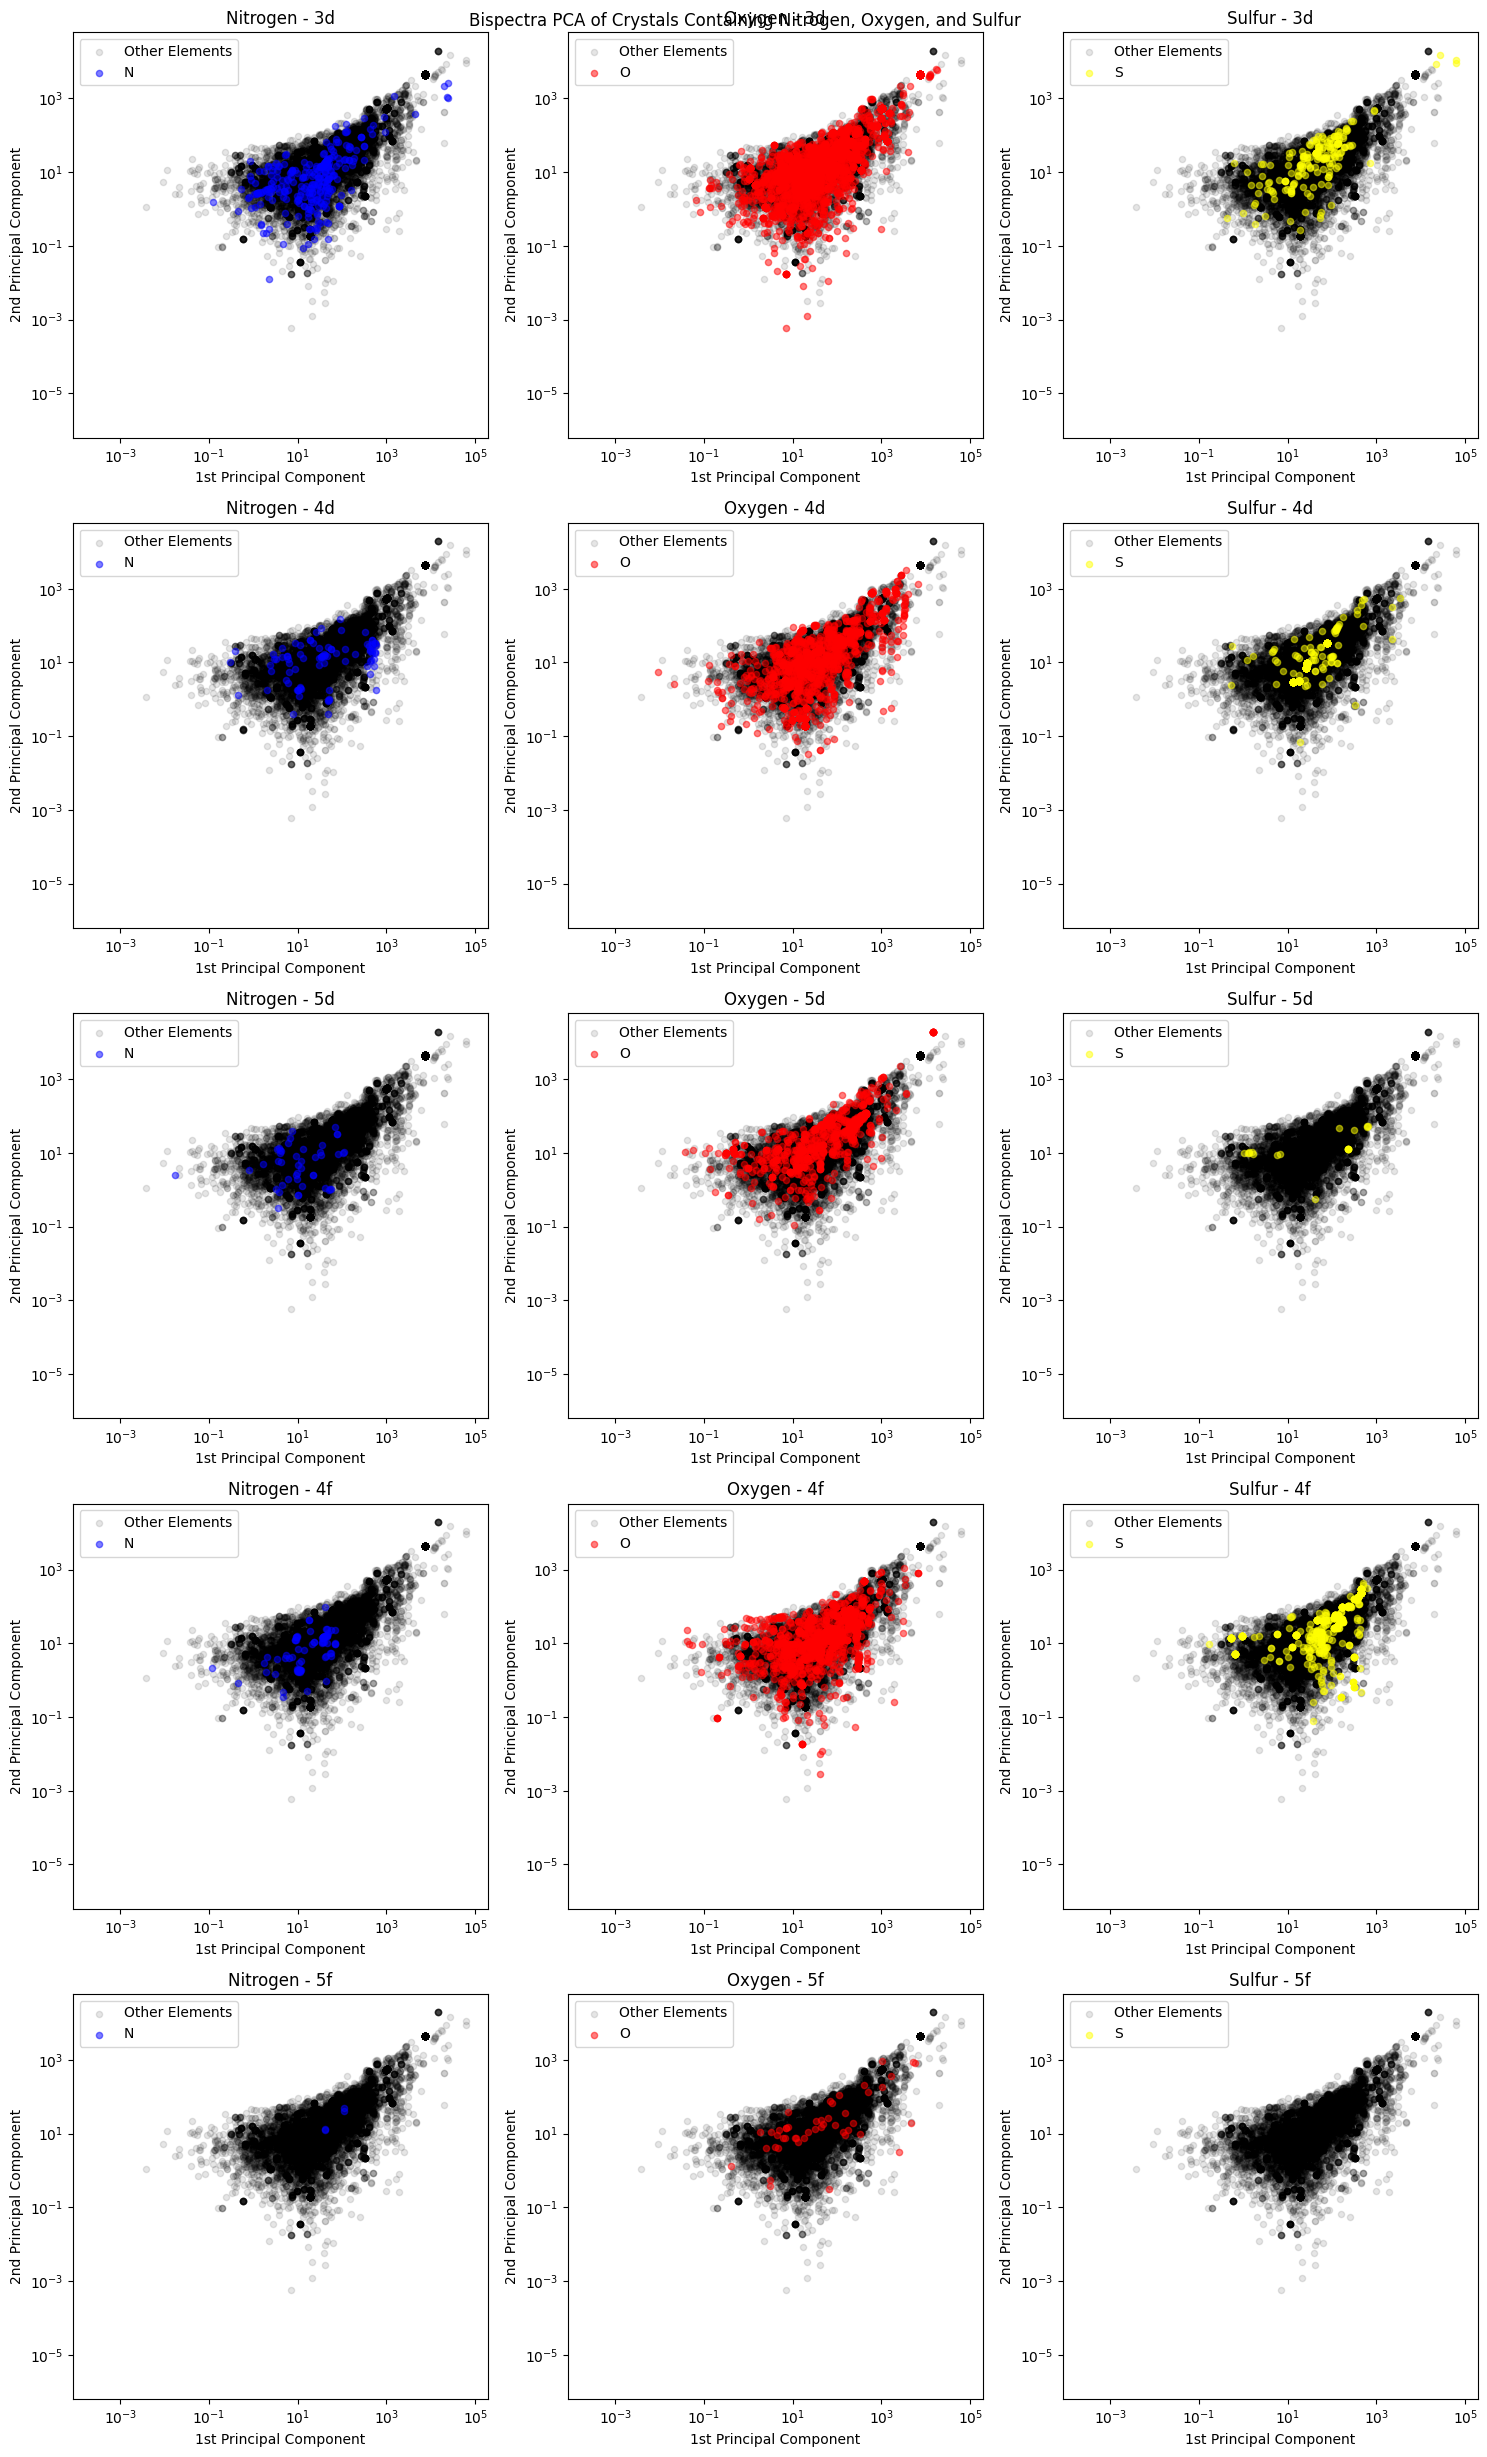

In [9]:
fig, axs = plt.subplots(5, 3, figsize=(15, 25))
fig.suptitle('Bispectra PCA of Crystals Containing Nitrogen, Oxygen, and Sulfur')

NOS_elements = ['N', 'O', 'S']
transition_metal_series = ['3d', '4d', '5d', '4f', '5f']
symbol_to_element = {'N': 'Nitrogen', 'O': 'Oxygen', 'S': 'Sulfur'}
colors = ['blue', 'red', 'yellow']

for i, NOS_element in enumerate(NOS_elements):
    for j, series in enumerate(transition_metal_series):
        ax = axs[j, i]
        group = df_transition_metal_crystals[(df_transition_metal_crystals['NOS_element'] == NOS_element) & (df_transition_metal_crystals['transition_metal_series'] == series)]
        other_group = df_transition_metal_crystals[(df_transition_metal_crystals['NOS_element'] != NOS_element) | (df_transition_metal_crystals['transition_metal_series'] != series)]
        ax.set_title(f'{symbol_to_element[NOS_element]} - {series}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Other Elements')
        group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=colors[i], alpha=0.5, label=NOS_element)
        ax.legend()

plt.tight_layout()
plt.show()


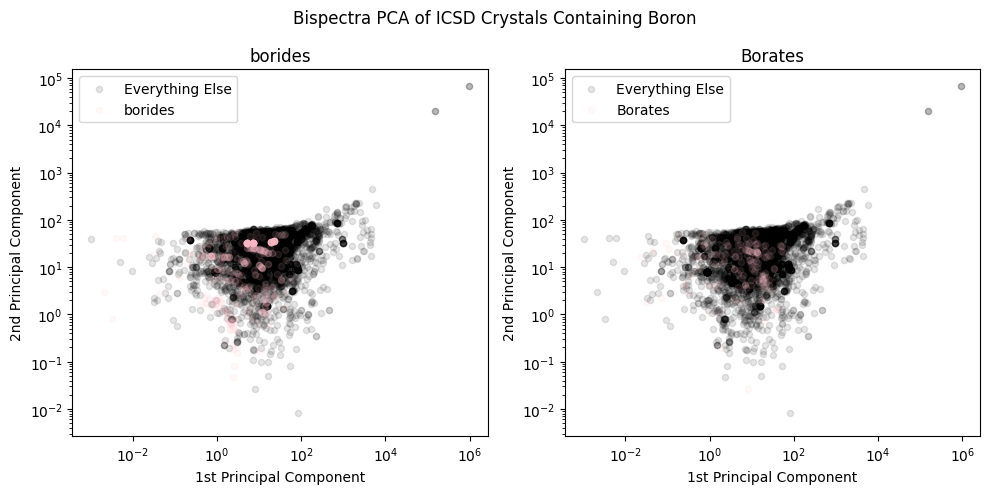

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Bispectra PCA of ICSD Crystals Containing Boron')

boron_forms = ['boride', 'borate']
symbol_to_boron_form = {'boride': 'borides', 'borate': 'Borates'}
colors = ['pink', 'pink']

for ax, boron_form, color in zip(axs, boron_forms, colors):
    group = df_all_crystals[df_all_crystals['boron'] == boron_form]
    other_group = df_all_crystals[df_all_crystals['boron'] != boron_form]
    ax.set_title(f'{symbol_to_boron_form[boron_form]}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Everything Else')
    group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=color, alpha=0.1, label=symbol_to_boron_form[boron_form])
    ax.legend()

plt.tight_layout()
plt.show()

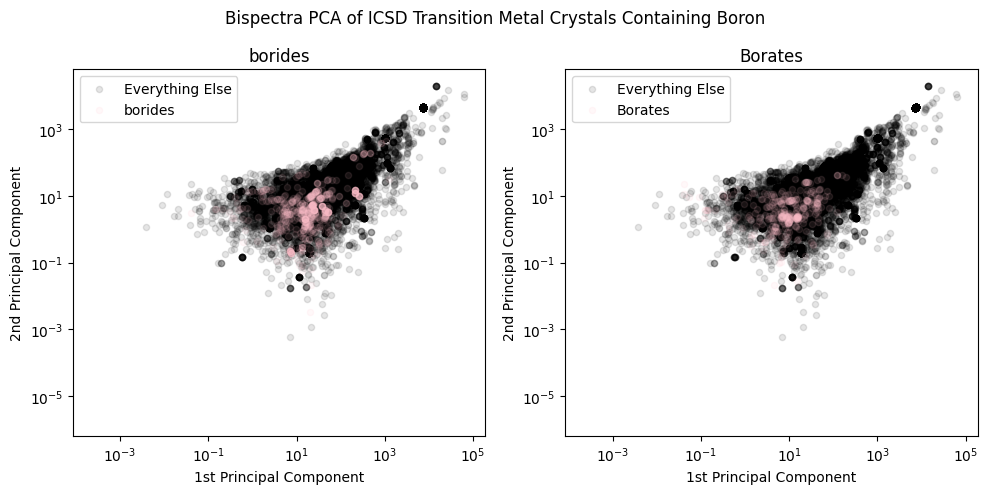

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Bispectra PCA of ICSD Transition Metal Crystals Containing Boron')

boron_forms = ['boride', 'borate']
symbol_to_boron_form = {'boride': 'borides', 'borate': 'Borates'}
colors = ['pink', 'pink']

for ax, boron_form, color in zip(axs, boron_forms, colors):
    group = df_transition_metal_crystals[df_transition_metal_crystals['boron'] == boron_form]
    other_group = df_transition_metal_crystals[df_transition_metal_crystals['boron'] != boron_form]
    ax.set_title(f'{symbol_to_boron_form[boron_form]}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    other_group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color='black', alpha=0.1, label='Everything Else')
    group.plot(ax=ax, kind='scatter', x='1st Principal Component', y='2nd Principal Component', color=color, alpha=0.1, label=symbol_to_boron_form[boron_form])
    ax.legend()

plt.tight_layout()
plt.show()